In [2]:
from keras.datasets import cifar10
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model, Input
from keras.datasets import cifar10
from keras.utils import np_utils,plot_model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D ,MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, UpSampling2D, concatenate
from sklearn import metrics
from tensorflow.keras import backend as K 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, SGD, RMSprop

from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet201,preprocess_input
from keras.applications import VGG16 ,InceptionResNetV2

np.random.seed(42)

Using TensorFlow backend.


In [2]:
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left') 
    plt.show()


In [3]:
(x_img_train, y_label_train),(x_img_test,y_label_test)=cifar10.load_data()

In [4]:
print("train data", 'images', x_img_train.shape,
      "labels", y_label_train.shape)
print("test data", 'images', x_img_test.shape,
      "labels", y_label_test.shape)


train data images (50000, 32, 32, 3) labels (50000, 1)
test data images (10000, 32, 32, 3) labels (10000, 1)


In [5]:
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True)

datagen =  ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_img_train)

In [6]:
x_img_train_normalize = x_img_train.copy()
x_img_test_normalize = x_img_test.copy()
x_img_train_normalize = x_img_train.astype('float32') / 255.0
x_img_test_normalize = x_img_test.astype('float32') / 255.0

In [7]:

y_label_train_OneHot = np_utils.to_categorical(y_label_train)
y_label_test_OneHot = np_utils.to_categorical(y_label_test)

X_train, X_test, y_train, y_test = train_test_split(x_img_train_normalize, y_label_train_OneHot, test_size=0.33)


In [8]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [9]:
# model = Sequential()
# model.add(Conv2D(filters=64, kernel_size=3, input_shape=(32, 32, 3), activation='relu', padding='same'))
# model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
# model.add(MaxPool2D(pool_size=2))

# model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
# model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
# model.add(MaxPool2D(pool_size=2))

# model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
# model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
# model.add(MaxPool2D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(rate=0.25))
# model.add(Dense(10, activation='softmax'))

# DenseNet

In [10]:
DenseNet201_model = DenseNet201(include_top=False, weights="imagenet", input_shape=(32,32,3))
# model = add_new_last_layer(model, 3)

# net.trainable = False
model = Sequential()
model.add(DenseNet201_model)
# model.add(Dropout(0.2))
# model.add(Conv2D(256, (3, 3), activation = 'relu', padding='same'))
model.add(Flatten()) 
model.add(Dropout(0.5)) 
model.add(Dense(256, activation='relu')) 
# model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.1)) 
model.add(Dense(10, activation='softmax')) 


print(model.summary())
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
callback_save = keras.callbacks.ModelCheckpoint(filepath='C:/Users/mb207/Desktop/py/save/desnet.ckpt', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=1e-4), metrics = ['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1, 1, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 18,816,330
Trainable params: 18,587,274
Non-trainable params: 229,056
______________________________________

In [11]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(x_img_train_normalize, y_label_train_OneHot, epochs=10, batch_size=64, verbose=1)
history = model.fit_generator(X_train,y_train,batch_size=20, 
                               epochs=500,
                              validation_data=(X_test,y_test),callbacks=[earlystopping,callback_save])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/500
500/500 [==============================] - ETA: 0s - loss: 1.7846 - accuracy: 0.3743
Epoch 00001: val_accuracy improved from -inf to 0.61945, saving model to C:/Users/mb207/Desktop/py/save/desnet.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:/Users/mb207/Desktop/py/save/desnet.ckpt\assets
500/500 [==============================] - 215s 431ms/step - loss: 1.7846 - accuracy: 0.3743 - val_loss: 1.1490 - val_accuracy: 0.6195
Epoch 2/500
500/500 [==============================] - ETA: 0s - loss: 1.2286 - accuracy: 0.5896
Epoch 00002: val_accuracy improved from 0.61945 to 0.69758, saving model to C:/Users/mb207/Desktop/py/save/desnet.ckpt
INFO:tensorflow:Assets written to: C:/Users/mb207/Desktop/py/save/desnet.ckpt\assets
500/500 [==============================] - 214s 428ms/step - loss: 1.2286 - accuracy: 0.5896 - val_loss: 0.97

In [12]:
loss, accuracy = model.evaluate(x_img_test_normalize, y_label_test_OneHot)
pred = model.predict(x_img_test_normalize)

313/313 [==============================] - 20s 65ms/step - loss: 8.1575 - accuracy: 0.7933


313/313 [==============================] - 19s 61ms/step - loss: 8.1575 - accuracy: 0.7933
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Loss: 8.157470703125
Accuracy: 0.7932999730110168
predict accurscy: 0.7933, precision: 0.8170482325395259, recall: 0.7933000000000001, f1 : 0.7949109758548543


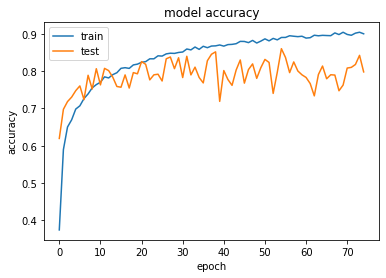

In [13]:

# model.load_weights('py/mango')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(x_img_test_normalize,y_label_test_OneHot)
pred_cy = model.predict_classes(x_img_test_normalize)

precision = precision_score(y_label_test, pred_cy, average='macro')
recall = recall_score(y_label_test, pred_cy, average='macro')
acc = accuracy_score(y_label_test, pred_cy)
f1 = f1_score(y_label_test, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1 : {f1}')
plot_acc(history)


# VGG16

In [18]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (32 ,32,3))

# conv_base.trainable = False
model = Sequential()
model.add(conv_base)
# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(64, activation = 'relu'))
# # model.add(Dropout(0.1))
# model.add(Dense(3, activation = 'softmax'))


# model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Flatten()) 
model.add(Dropout(0.5)) 
model.add(Dense(128, activation='relu')) 
# model.add(Dropout(0.5)) 
model.add(Dense(10, activation='softmax')) 


print(model.summary())
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
callback_save = keras.callbacks.ModelCheckpoint(filepath='C:/Users/mb207/Desktop/py/save/VGG.ckpt', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=1e-4), metrics = ['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 14,781,642
Trainable params: 14,781,642
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(x_img_train_normalize, y_label_train_OneHot, epochs=10, batch_size=64, verbose=1)
history = model.fit_generator(X_train,y_train,batch_size=20, 
                               epochs=500,
                              validation_data=(X_test,y_test),callbacks=[earlystopping,callback_save])

Epoch 1/500
500/500 [==============================] - ETA: 0s - loss: 1.7843 - accuracy: 0.3598
Epoch 00001: val_accuracy improved from -inf to 0.61218, saving model to C:/Users/mb207/Desktop/py/save/VGG.ckpt
INFO:tensorflow:Assets written to: C:/Users/mb207/Desktop/py/save/VGG.ckpt\assets
500/500 [==============================] - 27s 55ms/step - loss: 1.7843 - accuracy: 0.3598 - val_loss: 1.1081 - val_accuracy: 0.6122
Epoch 2/500
499/500 [============================>.] - ETA: 0s - loss: 1.2118 - accuracy: 0.6028
Epoch 00002: val_accuracy improved from 0.61218 to 0.67497, saving model to C:/Users/mb207/Desktop/py/save/VGG.ckpt
INFO:tensorflow:Assets written to: C:/Users/mb207/Desktop/py/save/VGG.ckpt\assets
500/500 [==============================] - 26s 52ms/step - loss: 1.2120 - accuracy: 0.6027 - val_loss: 0.9780 - val_accuracy: 0.6750
Epoch 3/500
500/500 [==============================] - ETA: 0s - loss: 1.0060 - accuracy: 0.6758
Epoch 00003: val_accuracy did not improve from 0.6

In [20]:
loss, accuracy = model.evaluate(x_img_test_normalize, y_label_test_OneHot)
pred = model.predict(x_img_test_normalize)

313/313 [==============================] - 5s 16ms/step - loss: 1.0365 - accuracy: 0.6870


313/313 [==============================] - 4s 14ms/step - loss: 1.0365 - accuracy: 0.6870
Loss: 1.0364726781845093
Accuracy: 0.6869999766349792
predict accurscy: 0.687, precision: 0.7111171057621888, recall: 0.6869999999999999, f1 : 0.6749089143243256


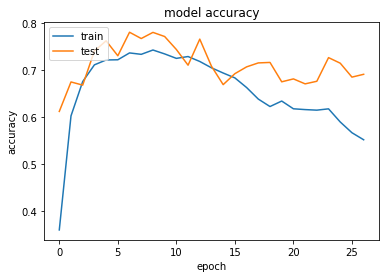

In [21]:
# model.load_weights('py/mango')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(x_img_test_normalize,y_label_test_OneHot)
pred_cy = model.predict_classes(x_img_test_normalize)

precision = precision_score(y_label_test, pred_cy, average='macro')
recall = recall_score(y_label_test, pred_cy, average='macro')
acc = accuracy_score(y_label_test, pred_cy)
f1 = f1_score(y_label_test, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1 : {f1}')
plot_acc(history)


# Base_CNN

In [30]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (32,32,3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(180, (3, 3), activation = 'relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
# model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(Dense(128, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))
print(model.summary())


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
callback_save = keras.callbacks.ModelCheckpoint(filepath='C:/Users/mb207/Desktop/py/save/CNN.ckpt', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 64)         

In [31]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(x_img_train_normalize, y_label_train_OneHot, epochs=10, batch_size=64, verbose=1)
history = model.fit_generator(X_train,y_train,batch_size=20, 
                               epochs=500,
                              validation_data=(X_test,y_test),callbacks=[earlystopping,callback_save])

Epoch 1/500
500/500 [==============================] - ETA: 0s - loss: 1.9338 - accuracy: 0.2725
Epoch 00001: val_accuracy improved from -inf to 0.37430, saving model to C:/Users/mb207/Desktop/py/save/CNN.ckpt
INFO:tensorflow:Assets written to: C:/Users/mb207/Desktop/py/save/CNN.ckpt\assets
500/500 [==============================] - 19s 37ms/step - loss: 1.9338 - accuracy: 0.2725 - val_loss: 1.6565 - val_accuracy: 0.3743
Epoch 2/500
499/500 [============================>.] - ETA: 0s - loss: 1.6521 - accuracy: 0.3883
Epoch 00002: val_accuracy improved from 0.37430 to 0.44636, saving model to C:/Users/mb207/Desktop/py/save/CNN.ckpt
INFO:tensorflow:Assets written to: C:/Users/mb207/Desktop/py/save/CNN.ckpt\assets
500/500 [==============================] - 19s 38ms/step - loss: 1.6513 - accuracy: 0.3887 - val_loss: 1.4840 - val_accuracy: 0.4464
Epoch 3/500
499/500 [============================>.] - ETA: 0s - loss: 1.5108 - accuracy: 0.4448
Epoch 00003: val_accuracy improved from 0.44636 to

In [32]:
loss, accuracy = model.evaluate(x_img_test_normalize, y_label_test_OneHot)
pred = model.predict(x_img_test_normalize)

313/313 [==============================] - 3s 9ms/step - loss: 0.7862 - accuracy: 0.7646


313/313 [==============================] - 3s 9ms/step - loss: 0.7862 - accuracy: 0.7646
Loss: 0.7862129211425781
Accuracy: 0.7645999789237976
predict accurscy: 0.7646, precision: 0.7635471086549634, recall: 0.7646, f1 : 0.7602243628285221


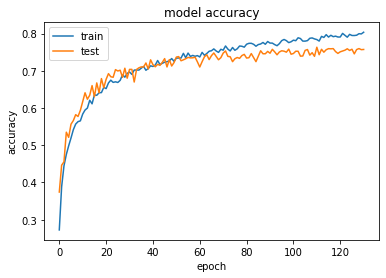

In [33]:
# model.load_weights('py/mango')
# loss, accuracy = model.evaluate(test_datagen.flow(test_x, test_y))
loss,accuracy=model.evaluate(x_img_test_normalize,y_label_test_OneHot)
pred_cy = model.predict_classes(x_img_test_normalize)

precision = precision_score(y_label_test, pred_cy, average='macro')
recall = recall_score(y_label_test, pred_cy, average='macro')
acc = accuracy_score(y_label_test, pred_cy)
f1 = f1_score(y_label_test, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1 : {f1}')
plot_acc(history)

# InceptionResNetV2

In [2]:
# net = InceptionResNetV2(include_top=False, input_tensor=None,weights="imagenet",
#                 input_shape=(32,32,3))
# x = net.output
# x = Flatten()(x)
# x = Dense(256, activation='relu')(x)
# # 增加 DropOut layer
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# output_layer = Dense(10, activation='softmax', name='softmax')(x)
# model = Model(inputs=net.input, outputs=output_layer)
# model.compile(optimizer=Adam(lr=1e-5),
#                   loss='categorical_crossentropy', metrics=['accuracy'])
# earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
# callback_save = keras.callbacks.ModelCheckpoint(filepath='C:/Users/mb207/Desktop/py/save/InceptionResNetV2.ckpt', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
# print(model.summary())

In [ ]:
history = model.fit_generator(X_train,y_train,batch_size=20, 
                               epochs=500,
                              validation_data=(X_test,y_test),callbacks=[earlystopping,callback_save])

In [ ]:
loss, accuracy = model.evaluate(x_img_test_normalize, y_label_test_OneHot)
pred = model.predict(x_img_test_normalize)

In [ ]:
loss,accuracy=model.evaluate(x_img_test_normalize,y_label_test_OneHot)
pred_cy = model.predict_classes(x_img_test_normalize)

precision = precision_score(y_label_test, pred_cy, average='macro')
recall = recall_score(y_label_test, pred_cy, average='macro')
acc = accuracy_score(y_label_test, pred_cy)
f1 = f1_score(y_label_test, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1 : {f1}')
plot_acc(history)

# ResNet50

In [35]:
net = ResNet50(include_top=False, input_tensor=None,weights="imagenet",
                input_shape=(32,32,3))
x = net.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
# 增加 DropOut layer
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(10, activation='softmax', name='softmax')(x)
model = Model(inputs=net.input, outputs=output_layer)
model.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
callback_save = keras.callbacks.ModelCheckpoint(filepath='C:/Users/mb207/Desktop/py/save/Resnet50.ckpt', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [36]:
history = model.fit_generator(X_train,y_train,batch_size=20, 
                               epochs=500,
                              validation_data=(X_test,y_test),callbacks=[earlystopping,callback_save])

Epoch 1/500
500/500 [==============================] - ETA: 0s - loss: 2.6811 - accuracy: 0.1212
Epoch 00001: val_accuracy improved from -inf to 0.10248, saving model to C:/Users/mb207/Desktop/py/save/Resnet50.ckpt
INFO:tensorflow:Assets written to: C:/Users/mb207/Desktop/py/save/Resnet50.ckpt\assets
500/500 [==============================] - 91s 183ms/step - loss: 2.6811 - accuracy: 0.1212 - val_loss: 81.8923 - val_accuracy: 0.1025
Epoch 2/500
500/500 [==============================] - ETA: 0s - loss: 2.3676 - accuracy: 0.1692
Epoch 00002: val_accuracy improved from 0.10248 to 0.21048, saving model to C:/Users/mb207/Desktop/py/save/Resnet50.ckpt
INFO:tensorflow:Assets written to: C:/Users/mb207/Desktop/py/save/Resnet50.ckpt\assets
500/500 [==============================] - 86s 173ms/step - loss: 2.3676 - accuracy: 0.1692 - val_loss: 2.2523 - val_accuracy: 0.2105
Epoch 3/500
500/500 [==============================] - ETA: 0s - loss: 2.2059 - accuracy: 0.2193
Epoch 00003: val_accuracy i

In [37]:
loss, accuracy = model.evaluate(x_img_test_normalize, y_label_test_OneHot)
pred = model.predict(x_img_test_normalize)

313/313 [==============================] - 9s 28ms/step - loss: 0.5559 - accuracy: 0.8301


313/313 [==============================] - 8s 27ms/step - loss: 0.5559 - accuracy: 0.8301
Loss: 0.555915892124176
Accuracy: 0.8300999999046326
predict accurscy: 0.8301, precision: 0.8301999803091423, recall: 0.8301000000000001, f1 : 0.8290699686116352


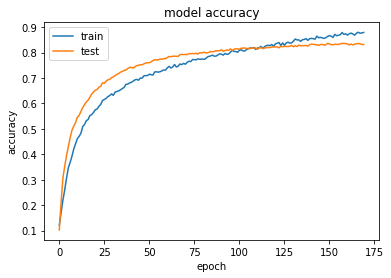

In [42]:
loss,accuracy=model.evaluate(x_img_test_normalize,y_label_test_OneHot)
# pred_cy = model.predict_classes(x_img_test_normalize)
pred_cy = model.predict(x_img_test_normalize)
pred_cy=np.argmax(pred_cy,axis=1)
precision = precision_score(y_label_test, pred_cy, average='macro')
recall = recall_score(y_label_test, pred_cy, average='macro')
acc = accuracy_score(y_label_test, pred_cy)
f1 = f1_score(y_label_test, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1 : {f1}')
plot_acc(history)

# DenseNet

In [ ]:
from keras.models import load_model
model= load_model('C:/Users/mb207/Desktop/py/save/desnet.ckpt')
loss, accuracy = model.evaluate(x_img_test_normalize, y_label_test_OneHot, verbose=1)

pred_cy = model.predict(x_img_test_normalize)
precision = precision_score(y_label_test, pred_cy, average='macro')
recall = recall_score(y_label_test, pred_cy, average='macro')
acc = accuracy_score(y_label_test, pred_cy)
f1 = f1_score(y_label_test, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1 : {f1}')


# VGG

In [ ]:
from keras.models import load_model
model= load_model('C:/Users/mb207/Desktop/py/save/VGG.ckpt')
loss, accuracy = model.evaluate(x_img_test_normalize, y_label_test_OneHot, verbose=1)
pred = model.predict(x_img_test_normalize)
loss,accuracy=model.evaluate(x_img_test_normalize,y_label_test_OneHot)
pred_cy = model.predict_classes(x_img_test_normalize)
precision = precision_score(y_label_test, pred_cy, average='macro')
recall = recall_score(y_label_test, pred_cy, average='macro')
acc = accuracy_score(y_label_test, pred_cy)
f1 = f1_score(y_label_test, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1 : {f1}')

# Base_CNN

In [ ]:
model= load_model('C:/Users/mb207/Desktop/py/save/CNN.ckpt')

loss,accuracy=model.evaluate(x_img_test_normalize,y_label_test_OneHot)
pred_cy = model.predict_classes(x_img_test_normalize)
precision = precision_score(y_label_test, pred_cy, average='macro')
recall = recall_score(y_label_test, pred_cy, average='macro')
acc = accuracy_score(y_label_test, pred_cy)
f1 = f1_score(y_label_test, pred_cy, average='macro')
print('Loss:', loss)
print('Accuracy:', accuracy)
print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1 : {f1}')

# InceptionResNetV2

In [ ]:
# model= load_model('C:/Users/mb207/Desktop/py/save/InceptionResNetV2.ckpt')
# loss, accuracy = model.evaluate(x_img_test_normalize, y_label_test_OneHot, verbose=1)
# pred = model.predict(x_img_test_normalize)
# loss,accuracy=model.evaluate(x_img_test_normalize,y_label_test_OneHot)
# pred_cy = model.predict_classes(x_img_test_normalize)
# precision = precision_score(y_label_test, pred_cy, average='macro')
# recall = recall_score(y_label_test, pred_cy, average='macro')
# acc = accuracy_score(y_label_test, pred_cy)
# f1 = f1_score(y_label_test, pred_cy, average='macro')
# print('Loss:', loss)
# print('Accuracy:', accuracy)
# print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1 : {f1}')

# Resnet50

In [1]:
# model= load_model('py/mango4.ckpt')

# loss,accuracy=model.evaluate(x_img_test_normalize,y_label_test_OneHot)
# pred_cy = model.predict_classes(x_img_test_normalize)
# precision = precision_score(y_label_test, pred_cy, average='macro')
# recall = recall_score(y_label_test, pred_cy, average='macro')
# acc = accuracy_score(y_label_test, pred_cy)
# f1 = f1_score(y_label_test, pred_cy, average='macro')
# print('Loss:', loss)
# print('Accuracy:', accuracy)
# print(f'predict accurscy: {acc}, precision: {precision}, recall: {recall}, f1 : {f1}')